# NODE 

Neural Oblivious Decision Ensembles

differentiable oblivious desicion trees (ODT) that are trained end-to-end by backpropagation.

https://paperswithcode.com/method/node


## Node Multiclass Classification


In [1]:
## Librerias
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Optimization
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

## visualization
import seaborn as sns
import matplotlib.pyplot as plt

## preprocessing
import pandas as pd
import numpy as np

## Class Node Multiclass Classification

In [2]:
class NODEModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=64, num_trees=10):
        super(NODEModel, self).__init__()
        self.trees = nn.ModuleList([nn.Linear(input_dim, hidden_dim) for _ in range(num_trees)])
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.output_layer = nn.Linear(hidden_dim * num_trees, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pass through each tree and concatenate outputs
        tree_outputs = [torch.relu(tree(x)) for tree in self.trees]
        x = torch.cat(tree_outputs, dim=1)
        # Final multiclass prediction
        x = self.output_layer(x)
        return self.softmax(x)


### Experiment Gesture Phase

In [31]:
## Load data
base_path = 'homeworks/data/project/gesture_phase/'
df = pd.read_csv(base_path + 'gesture_phase.csv')

In [41]:
df.columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', 'Phase'],
      dtype='object')

In [50]:
## Preprocessing
X = df.drop('Phase',axis=1).values
y = df['Phase'].values
le = LabelEncoder()
# Fit and transform the data to the label encoder
y = le.fit_transform(y_target)
print('Labels:', labels)
#X = df.values[:, :-1]
#y_target = df.values[:, -1]
labels = np.unique(y_target)

# Initialize the LabelEncoder

# Convertir a tensores de PyTorch
X = torch.FloatTensor(X)
y = torch.LongTensor(y)


Labels: tensor([2, 2, 4, 3, 0, 2, 3, 1, 0, 0, 2, 2, 0, 2, 1, 5, 4, 4, 5, 1, 2, 3, 5, 0,
        4, 4, 5, 0, 3, 0, 3, 0])


In [51]:

## Split into train and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 2:Train and validation data  70% train y 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [59]:
input_dim = X_train.shape[1]
num_classes = 5

model = NODEModel(input_dim=input_dim, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss for multiclass classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Training loop
num_epochs = 20
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# store log losses
log_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        log_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Step 5: Evaluation on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_probs = torch.nn.functional.softmax(test_outputs, dim=1)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_log_loss = log_loss(y_test, test_probs)

print(f'Accuracy on Test Set: {test_accuracy:.4f}')
print(f'Log Loss on Test Set: {test_log_loss:.4f}')


Epoch 1/20, Loss: 1.5516
Epoch 2/20, Loss: 1.5116
Epoch 3/20, Loss: 1.4779
Epoch 4/20, Loss: 1.4616
Epoch 5/20, Loss: 1.4547
Epoch 6/20, Loss: 1.4495
Epoch 7/20, Loss: 1.4462
Epoch 8/20, Loss: 1.4424
Epoch 9/20, Loss: 1.4397
Epoch 10/20, Loss: 1.4370
Epoch 11/20, Loss: 1.4337
Epoch 12/20, Loss: 1.4293
Epoch 13/20, Loss: 1.4267
Epoch 14/20, Loss: 1.4233
Epoch 15/20, Loss: 1.4214
Epoch 16/20, Loss: 1.4190
Epoch 17/20, Loss: 1.4181
Epoch 18/20, Loss: 1.4159
Epoch 19/20, Loss: 1.4153
Epoch 20/20, Loss: 1.4144
Accuracy on Test Set: 0.4922
Log Loss on Test Set: 1.4121


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


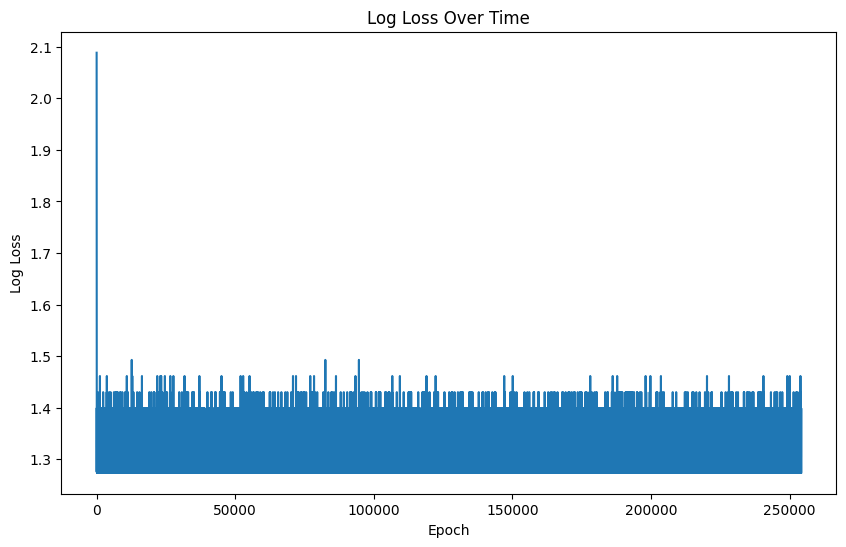

In [10]:
## Log loss visualization
plt.figure(figsize=(10, 6))
plt.plot(log_losses)
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Log Loss Over Time')
plt.show()

In [11]:
report = classification_report(y_test, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       448
           1       0.00      0.00      0.00       426
           2       0.00      0.00      0.00       440
           3       0.00      0.00      0.00       422
           4       0.00      0.00      0.00       452
           5       0.00      0.00      0.00       417
           6       0.00      0.00      0.00       411
           7       0.97      1.00      0.99    113187

    accuracy                           0.97    116203
   macro avg       0.12      0.12      0.12    116203
weighted avg       0.95      0.97      0.96    116203



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

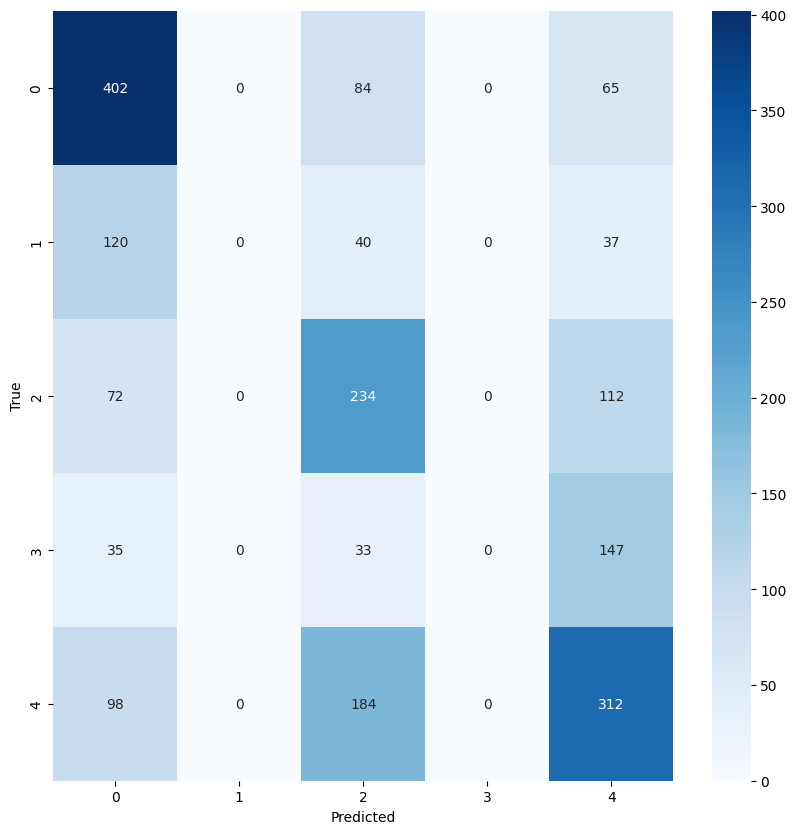

In [58]:
# Compute confusion matrix
cm = confusion_matrix(y_test, test_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Experiments with Cover Type


In [3]:
base_path = 'homeworks/data/project/'
df_cover = pd.read_csv(base_path + 'forest_cover.csv')

In [4]:
df_cover = df_cover.drop('Id', axis=1)

In [5]:
df_cover.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [26]:
## Preprocessing
X = df_cover.drop('Cover_Type',axis=1).values
y = df_cover['Cover_Type'].values

## Stadarize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

le = LabelEncoder()
# Fit and transform the data to the label encoder
y = le.fit_transform(y)
print(np.unique(y))

X = torch.FloatTensor(X)
y = torch.LongTensor(y)

[0 1 2 3 4 5 6 7]


In [27]:
X.shape, y.shape

(torch.Size([581012, 54]), torch.Size([581012]))

In [28]:
## Split into train and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 2:Train and validation data  70% train y 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [29]:
## Train the model

input_dim = X_train.shape[1]
num_classes = 8

model = NODEModel(input_dim=input_dim, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss for multiclass classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Training loop
num_epochs = 20
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# store log losses
log_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        log_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

# Step 5: Evaluation on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_probs = torch.nn.functional.softmax(test_outputs, dim=1)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_log_loss = log_loss(y_test, test_probs)

print(f'Accuracy on Test Set: {test_accuracy:.4f}')
print(f'Log Loss on Test Set: {test_log_loss:.4f}')


Epoch 1/20, Loss: 1.3006
Epoch 2/20, Loss: 1.3000
Epoch 3/20, Loss: 1.3000
Epoch 4/20, Loss: 1.3000
Epoch 5/20, Loss: 1.3000
Epoch 6/20, Loss: 1.3000
Epoch 7/20, Loss: 1.3000
Epoch 8/20, Loss: 1.3000
Epoch 9/20, Loss: 1.3000
Epoch 10/20, Loss: 1.3000
Epoch 11/20, Loss: 1.3000
Epoch 12/20, Loss: 1.3000
Epoch 13/20, Loss: 1.3000
Epoch 14/20, Loss: 1.3000
Epoch 15/20, Loss: 1.3000
Epoch 16/20, Loss: 1.3000
Epoch 17/20, Loss: 1.3000
Epoch 18/20, Loss: 1.3000
Epoch 19/20, Loss: 1.3000
Epoch 20/20, Loss: 1.3000
Accuracy on Test Set: 0.9740
Log Loss on Test Set: 1.3000


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [12]:
report = classification_report(y_test, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       448
           1       0.00      0.00      0.00       426
           2       0.00      0.00      0.00       440
           3       0.00      0.00      0.00       422
           4       0.00      0.00      0.00       452
           5       0.00      0.00      0.00       417
           6       0.00      0.00      0.00       411
           7       0.97      1.00      0.99    113187

    accuracy                           0.97    116203
   macro avg       0.12      0.12      0.12    116203
weighted avg       0.95      0.97      0.96    116203



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## Experiments Binary Classification

In [30]:
# Paso 1:Model Architecture and Initialization Node
class BinaryNODEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_trees=10):
        super(BinaryNODEModel, self).__init__()
        self.trees = nn.ModuleList([nn.Linear(input_dim, hidden_dim) for _ in range(num_trees)])
        self.hidden_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_dim * num_trees, 1)  # Una sola neurona para salida binaria
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        tree_outputs = [torch.relu(tree(x)) for tree in self.trees]
        x = torch.cat(tree_outputs, dim=1)
        x = self.output_layer(x)
        return self.sigmoid(x)

In [31]:
## Load data
base_path = 'homeworks/data/project/'
df = pd.read_csv(base_path + 'shrutime_encoded.csv')
X = df.values[:, :-1]
y = df.values[:, -1].astype(int)


In [32]:
## Data Standardization

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

X = torch.FloatTensor(X_standardized)
y = torch.FloatTensor(y).unsqueeze(1)

In [33]:
## Split into train and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 2:Train and validation data  70% train y 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [34]:
model = BinaryNODEModel(input_dim=X_train.shape[1], hidden_dim=6, num_trees=10)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
    
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    
model.train()
for epoch in range(10):  # 10 epochs para optimización
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    log_loss_value = log_loss(y_test, test_outputs)
    test_preds = (test_outputs >= 0.5).float()
    accuracy = accuracy_score(y_test, test_preds)
    print(f'Log Loss: {log_loss_value:.4f}, Accuracy: {accuracy:.4f}')

Log Loss: 0.3481, Accuracy: 0.8550


In [35]:

report = classification_report(y_test, test_preds)
print(report)

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91      1607
         1.0       0.68      0.50      0.58       393

    accuracy                           0.85      2000
   macro avg       0.78      0.72      0.74      2000
weighted avg       0.84      0.85      0.85      2000



In [17]:
## Bayesian Optimization to seach for the best hyperparameters

space = {
    'hidden_dim': hp.choice('hidden_dim', range(1,100)),
    'num_trees': hp.choice('num_trees', range(1,100)),
    'output_dim': hp.choice('output_dim', [1]),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'batch_size': hp.choice('batch_size', [16,32,64,128]),
    
}


In [18]:
## Objective function to optimization
def objective(params):
    hidden_dim = int(params['hidden_dim'])
    num_trees = int(params['num_trees'])
    output_dim = int(params['output_dim'])
    learning_rate = params['learning_rate']
    batch_size = int(params['batch_size'])
    
    
    model = BinaryNODEModel(input_dim=X_train.shape[1], hidden_dim=hidden_dim, num_trees=num_trees)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for epoch in range(10):  # 10 epochs para optimización
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        log_loss_value = log_loss(y_test, test_outputs)
        test_preds = (test_outputs >= 0.5).float()
        accuracy = accuracy_score(y_test, test_preds)
    
    return {'accuracy': accuracy,'loss':log_loss_value, 'status': STATUS_OK}

# Paso 5: Optimización con hyperopt
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,  # Número de evaluaciones
            trials=trials)

print("Best Hyperparameters:", best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: 'int' object is not callable



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

TypeError: 'int' object is not callable

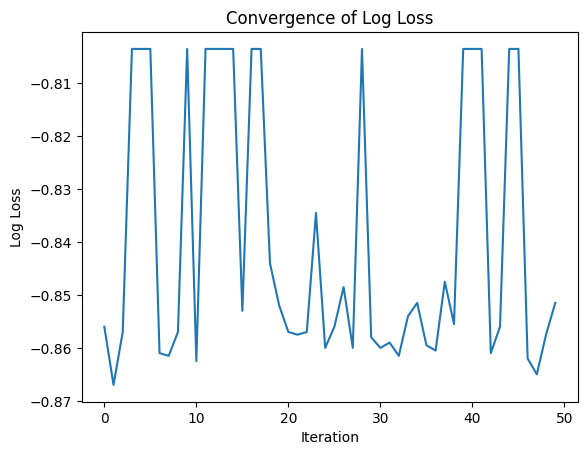

In [82]:
## Visualization of the loss and accuracy
loss_values = [result['accuracy'] for result in trials.results]
plt.plot(loss_values)
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Convergence of Log Loss')
plt.show()

In [77]:
trials.results

[{'accuracy': -0.856, 'loss': 0.3856357004169644, 'status': 'ok'},
 {'accuracy': -0.867, 'loss': 0.3413570601778917, 'status': 'ok'},
 {'accuracy': -0.857, 'loss': 0.3631687423969487, 'status': 'ok'},
 {'accuracy': -0.8035, 'loss': 7.08257789096152, 'status': 'ok'},
 {'accuracy': -0.8035, 'loss': 7.08257789096152, 'status': 'ok'},
 {'accuracy': -0.8035, 'loss': 7.08257789096152, 'status': 'ok'},
 {'accuracy': -0.861, 'loss': 0.3528270399524896, 'status': 'ok'},
 {'accuracy': -0.8615, 'loss': 0.33859699370041774, 'status': 'ok'},
 {'accuracy': -0.857, 'loss': 0.36692609699157847, 'status': 'ok'},
 {'accuracy': -0.8035, 'loss': 7.08257789096152, 'status': 'ok'},
 {'accuracy': -0.8625, 'loss': 0.3417723591439652, 'status': 'ok'},
 {'accuracy': -0.8035, 'loss': 7.08257789096152, 'status': 'ok'},
 {'accuracy': -0.8035, 'loss': 7.08257789096152, 'status': 'ok'},
 {'accuracy': -0.8035, 'loss': 7.08257789096152, 'status': 'ok'},
 {'accuracy': -0.8035, 'loss': 7.08257789096152, 'status': 'ok'},

In [60]:
print(trials.results)

[{'accuracy': -0.8035, 'loss': 7.08257789096152, 'status': 'ok'}, {'accuracy': -0.8035, 'loss': 7.08257789096152, 'status': 'ok'}, {'accuracy': -0.859, 'loss': 0.35421306650574286, 'status': 'ok'}, {'accuracy': -0.861, 'loss': 0.3496942024290504, 'status': 'ok'}, {'accuracy': -0.8035, 'loss': 7.08257789096152, 'status': 'ok'}, {'accuracy': -0.8535, 'loss': 0.3649782237644119, 'status': 'ok'}, {'accuracy': -0.851, 'loss': 0.3628934043319686, 'status': 'ok'}, {'accuracy': -0.867, 'loss': 0.3439170453087051, 'status': 'ok'}, {'accuracy': -0.8605, 'loss': 0.36252188035667987, 'status': 'ok'}, {'accuracy': -0.8625, 'loss': 0.34639938652604096, 'status': 'ok'}, {'accuracy': -0.854, 'loss': 0.34560904231500095, 'status': 'ok'}, {'accuracy': -0.8525, 'loss': 0.3549265724052794, 'status': 'ok'}, {'accuracy': -0.855, 'loss': 0.36822862292879627, 'status': 'ok'}, {'accuracy': -0.8035, 'loss': 7.08257789096152, 'status': 'ok'}, {'accuracy': -0.862, 'loss': 0.3429148362624013, 'status': 'ok'}, {'ac

In [79]:
# Traininig the model with the best hyperparameters
input_dim = X_train.shape[1]
hidden_dim = int(best['hidden_dim'])
num_trees = int( best['num_trees'])
batch_size = int(best['batch_size'])
model = BinaryNODEModel(input_dim=input_dim,hidden_dim=hidden_dim, num_trees=num_trees)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=best['learning_rate'])

num_epochs = 20
#batch_size = 32

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')




Epoch 1/20, Loss: 0.4718
Epoch 2/20, Loss: 0.4252
Epoch 3/20, Loss: 0.4063
Epoch 4/20, Loss: 0.3964
Epoch 5/20, Loss: 0.3790
Epoch 6/20, Loss: 0.3738
Epoch 7/20, Loss: 0.3671
Epoch 8/20, Loss: 0.3670
Epoch 9/20, Loss: 0.3681
Epoch 10/20, Loss: 0.3640
Epoch 11/20, Loss: 0.3583
Epoch 12/20, Loss: 0.3600
Epoch 13/20, Loss: 0.3581
Epoch 14/20, Loss: 0.3546
Epoch 15/20, Loss: 0.3537
Epoch 16/20, Loss: 0.3527
Epoch 17/20, Loss: 0.3487
Epoch 18/20, Loss: 0.3504
Epoch 19/20, Loss: 0.3485
Epoch 20/20, Loss: 0.3488


In [81]:

# Paso 5: Evaluación en el conjunto de prueba
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_preds = torch.sigmoid(test_outputs)

    test_preds = (test_outputs >= 0.5).float()  # Aplicar umbral para obtener predicciones binarias
    loss = log_loss(y_test, test_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    print(f'Accuracy on Test Set: {test_accuracy:.4f}')
    print(f'Log Loss on Test: {loss:.4f}')

Accuracy on Test Set: 0.8575
Log Loss on Test: 5.1362
